## This notebook attempts to create a model for binary text classification for Kaggle's Disaster Tweets competition. It follows the EDA notebook and uses DFs created with it.

In [1]:
!pip install transformers
!pip install sentencepiece

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from collections import defaultdict
from textwrap import wrap

import transformers
from transformers import  AdamW, get_linear_schedule_with_warmup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from transformers import DebertaV2Model, DebertaV2Tokenizer, RobertaModel, RobertaTokenizer
from string import punctuation
import re
import torch.nn.functional as F
import math
from scipy import stats
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

import torchtext
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn import feature_extraction, pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import xgboost
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_df = pd.read_csv('new_train.csv')
test_df = pd.read_csv('new_test.csv')

# Text preprocessing

Contractions, lowercase, stopwords, lemmatizing

In [4]:
def clean(tweet): 
    
    tweet = tweet.replace("`", "'")
    
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' .. ') 

    """
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)
    """
    
    # Contractions
    
    tweet = tweet.lower()

    tweet = re.sub(r"goooooooaaaaaal", "goal", tweet)
    tweet = re.sub(r"looooool", "lol", tweet)
    tweet = re.sub(r"im", "i am", tweet)
    tweet = re.sub(r"plumberto", "plumber to", tweet)
    tweet = re.sub(r" ww", "", tweet)
    tweet = re.sub(r"wasnt", "was not", tweet)
    tweet = re.sub(r"soo", "so", tweet)
    tweet = re.sub(r"nm", "never mind", tweet)
    tweet = re.sub(r"yer", "your", tweet)
    tweet = re.sub(r"gorjuz", "gorgeous", tweet)
    tweet = re.sub(r" u ", " you ", tweet)
    
    tweet = re.sub(r"btw", "by the way", tweet)
    tweet = re.sub(r"sooo", "so", tweet)
    tweet = re.sub(r"hes", "he is", tweet)
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"havent", "have not", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "i am", tweet)
    
    tweet = re.sub(r"here's", "here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
   
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
   
    tweet = re.sub(r"who's", "who is", tweet)
    
    tweet = re.sub(r"y'all", "you all", tweet)
    
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "i would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    
    tweet = re.sub(r"where's", "where is", tweet)
    
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "i will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "can not", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"you'd", "you would", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"could've", "could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet) 
    tweet = re.sub(r"donbt", "do not", tweet)
    tweet = re.sub(r"dont", "do not", tweet)
    tweet = re.sub(r"thats", "that is", tweet)

    tweet = re.sub(r"Typhoon-Devastated", "typhoon devastated", tweet)
    tweet = re.sub(r"TyphoonDevastated", "typhoon devastated", tweet)
    tweet = re.sub(r"typhoondevastated", "typhoon devastated", tweet)
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight", tweet)
    tweet = re.sub(r"MH", "Malaysia Airlines Flight", tweet)
    tweet = re.sub(r"mh370", "Malaysia Airlines Flight", tweet)
    tweet = re.sub(r"year-old", "years old", tweet)
    tweet = re.sub(r"yearold", "years old", tweet)
    tweet = re.sub(r"yr old", "years old", tweet)
    tweet = re.sub(r"PKK", "Kurdistan Workers Party", tweet)
    tweet = re.sub(r"MP", "madhya pradesh", tweet)
    tweet = re.sub(r"rly", "railway", tweet)
    tweet = re.sub(r"CDT", "Central Daylight Time", tweet)
    tweet = re.sub(r"sensorsenso", "sensor senso", tweet)
    tweet = re.sub(r"pm", "", tweet)
    tweet = re.sub(r"PM", "", tweet)
    tweet = re.sub(r"nan", " ", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"prebreak", "pre break", tweet)
    tweet = re.sub(r"nowplaying", "now playing", tweet)
    tweet = re.sub(r"RT", "retweet", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"Im", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "can not", tweet)
    tweet = re.sub(r"cant", "can not", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"dont", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)

    # Special characters
    tweet = re.sub(r"%20", " ", tweet)
    tweet = re.sub(r"%", " ", tweet)
    tweet = re.sub(r"@", " ", tweet)
    tweet = re.sub(r"#", " ", tweet)
    tweet = re.sub(r"'", " ", tweet)
    tweet = re.sub(r"\x89û_", " ", tweet)
    tweet = re.sub(r"\x89ûò", " ", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"re\x89û_", " ", tweet)
    tweet = re.sub(r"\x89û", " ", tweet)
    tweet = re.sub(r"\x89Û", " ", tweet)
    tweet = re.sub(r"re\x89Û", "re ", tweet)
    tweet = re.sub(r"re\x89û", "re ", tweet)
    tweet = re.sub(r"\x89ûª", "'", tweet)
    tweet = re.sub(r"\x89û", " ", tweet)
    tweet = re.sub(r"\x89ûò", " ", tweet)
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    
    tweet = re.sub(r"åÇ", "", tweet)
    
    tweet = re.sub(r"åÀ", "", tweet)

    # Words with punctuations and special characters
    punctuations = '@#!?+&[]-%.*:/();$=><|{}^'
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
    
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    tweet = re.sub('<.?>+', '', tweet)
    tweet = re.sub('[%s]' % re.escape(punctuation), '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\[.?\]', '', tweet)

    
    return tweet


In [5]:
train1 = train_df.copy()
test1 = test_df.copy()

train1['text_proc'] = train1['user_link_norm'].apply(lambda s: clean(s))
test1['text_proc'] = test1['user_link_norm'].apply(lambda s: clean(s))


In [6]:
def prepr(corpus):
  
  # Tokenization : In this each entry in the corpus will be broken into set of words
  corpus['text_proc']= [word_tokenize(entry) for entry in corpus['text_proc']]
  # Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
  # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV
  
  for index,entry in enumerate(corpus['text_proc']):
      # Declaring Empty List to store the words that follow the rules for this step
      Final_words = []
      s = ''
      # Initializing WordNetLemmatizer()
      word_Lemmatized = WordNetLemmatizer()
      # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
      for word, tag in pos_tag(entry):
          # Below condition is to check for Stop words and consider only alphabets
          if word not in stopwords.words('english') and word.isalpha():
              word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
              Final_words.append(word_Final)
      # The final processed set of words for each iteration will be stored in 'text_final'
      for i in Final_words:
        s+=(i+' ')
      
      corpus.loc[index,'text_final'] = s[:-1]
      

  return corpus


In [7]:
train1 =  prepr(train1.reset_index())
test1 =  prepr(test1.reset_index())

In [8]:
train1

,index,id,keyword,location,text,user_link_norm,target_relabeled,text_proc,text_final
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, earth...",deed reason earthquake may allah forgive u
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, shelter, in, place...",resident ask shelter place notify officer evac...
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",1,"[13000, people, receive, wildfires, evacuation...",people receive wildfire evacuation order calif...
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...",get send photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...,...,...
6903,6903,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,Two giant cranes holding a bridge collapse int...,1,"[two, giant, cranes, holding, a, bridge, colla...",two giant crane hold bridge collapse nearby ho...
6904,6904,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,@user @user The out of control wild fires in C...,1,"[user, user, the, out, of, control, wild, fire...",user user control wild fire california even no...
6905,6905,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http,1,"[m1, 94, 01, 04, utc, 5km, s, of, volcano, haw...",utc volcano hawaii http
6906,6906,10872,NaN,NaN,Police investigating after an e-bike collided ...,Police investigating after an e-bike collided ...,1,"[police, investigating, after, an, e, bike, co...",police investigate e bike collide car little p...


Train/valid split. As we can evaluate our models directly on Kaggle, we'll use train set for train and validation purposes only, leaving out test set to estimate public score on Kaggle

In [9]:
sep_idx = int(len(train1)*.8) #80/20%

In [10]:
y_train = train1[:sep_idx].target_relabeled.to_numpy()
y_valid = train1[sep_idx:].target_relabeled.to_numpy()

Evaluation metric for this challenge is F1 score, so we'll use it for baseline as well.

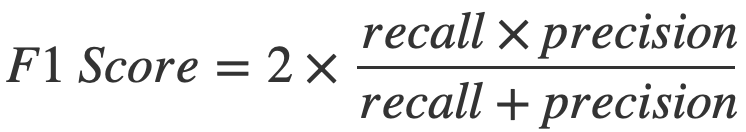

Baseline based on mode results in F1=0 as we get zero recall score and ill-defined precision (haven't classified any positive samples).

In [25]:
#mode for baseline
print('Baseline accuracy mode: ', accuracy_score(y_valid, [stats.mode(y_valid)[0][0]]*len(y_valid)))
print('Baseline f1 mode: ', f1_score(y_valid, [stats.mode(y_valid)[0][0]]*len(y_valid)))

Baseline accuracy mode:  0.5564399421128798
Baseline f1 mode:  0.0


We could also classify samples at random for baseline

In [28]:
#random for baseline
rand = [np.random.randint(2) for i in range(len(y_valid))]
print('Baseline accuracy random: ', accuracy_score(y_valid, rand))
print('Baseline f1 random: ', f1_score(y_valid, rand))

Baseline accuracy random:  0.48986975397973953
Baseline f1 random:  0.45977011494252873


# TF-IDF + LR/SVM/NB

tf-idf is a vectorization method that generates a value for each n-gram based on the respective significance of that n-gram in the context of the corpus and the given document. Generally, the more an n-gram occurs within a document and the less it occurs among other documents the more representative it is wrt this document (more important it is).

I'm using Logistic Regression, SVM and Naive Bayes classifiers here.

In [71]:
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,4))

lr = LogisticRegression(class_weight='balanced')
svm = LinearSVC(class_weight='balanced')
nb = MultinomialNB()

model_lr = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("log reg", lr)])
model_svm = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("svm", svm)])
model_nb = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("nb", nb)])

In [72]:
for model in [model_lr, model_svm, model_nb]:
  model.fit(train1[:sep_idx]["text_final"].values, y_train)
  predicted = model.predict(train1[sep_idx:]["text_final"].values)
  print(f'{model.steps[1][0]} f1 score is {f1_score(y_valid, predicted)}')

log reg f1 score is 0.7291338582677166
svm f1 score is 0.7072975140336808
nb f1 score is 0.65015479876161


We'll be considering 72,91% f1 as a baseline from here on

In [73]:
subm_lr = pd.read_csv('sample_submission.csv')
subm_lr['target'] = model_lr.predict(test1["text_final"].values)
subm_lr.to_csv('lr_tf-idf.csv', index=None)
# 0.78210 public score

# Glove + LSTM + simple attention

In [74]:
all_sentences = list(train1['text_final'])
all_sentences_test = list(test1['text_final'])

Here I'm using 200-dimensional Glove embeddings, pre-trained on twitter dataset

In [75]:
vocabulary = []

for i in all_sentences+all_sentences_test:
  for y in i.split():
    if y not in vocabulary:
      vocabulary.append(y)

# pretrained glove embeddings for twitter with dim of 200
glove = torchtext.vocab.GloVe(name="twitter.27B", dim=200)


.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [01:49<00:00, 10870.50it/s]


Creating embedding matrix, generate normal random embedding for words not found in embeddings

In [76]:
matrix_len = len(vocabulary)
weights_matrix = np.zeros((matrix_len+1, 200))

words_found = 0

for i, word in enumerate(vocabulary, start=1):
    if float(torch.sum(glove[word]))!=0.:
        weights_matrix[i] = glove[word]
        words_found += 1
    else:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(200, ))

print(f'Words found: {words_found} out of {len(vocabulary)}')

Words found: 12146 out of 14963


In [77]:
# function for inserting embeddings into neural net
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

voc_dic = {i:vocabulary.index(i)+1 for i in vocabulary}
print('Dictionary: ', voc_dic)

Dictionary:  {'deed': 1, 'reason': 2, 'earthquake': 3, 'may': 4, 'allah': 5, 'forgive': 6, 'u': 7, 'forest': 8, 'fire': 9, 'near': 10, 'la': 11, 'ronge': 12, 'sask': 13, 'canada': 14, 'resident': 15, 'ask': 16, 'shelter': 17, 'place': 18, 'notify': 19, 'officer': 20, 'evacuation': 21, 'order': 22, 'expect': 23, 'people': 24, 'receive': 25, 'wildfire': 26, 'california': 27, 'get': 28, 'send': 29, 'photo': 30, 'ruby': 31, 'alaska': 32, 'smoke': 33, 'pour': 34, 'school': 35, 'rockyfire': 36, 'update': 37, 'hwy': 38, 'close': 39, 'direction': 40, 'due': 41, 'lake': 42, 'county': 43, 'cafire': 44, 'flood': 45, 'disaster': 46, 'heavy': 47, 'rain': 48, 'cause': 49, 'flash': 50, 'flooding': 51, 'street': 52, 'manitou': 53, 'colorado': 54, 'spring': 55, 'area': 56, 'top': 57, 'hill': 58, 'see': 59, 'wood': 60, 'emergency': 61, 'happen': 62, 'building': 63, 'across': 64, 'afraid': 65, 'tornado': 66, 'come': 67, 'three': 68, 'die': 69, 'heat': 70, 'wave': 71, 'far': 72, 'haha': 73, 'south': 74, '

In [78]:
weights_matrix.shape

(14964, 200)

In [79]:
#tokenize
sentences_num = []

for i in all_sentences+all_sentences_test:
  sentences_num.append([voc_dic[y] for y in i.split()])

print('Tokenized: ', sentences_num[1])

Tokenized:  [8, 9, 10, 11, 12, 13, 14]


In [80]:
#tweets zero-padding
padded = pad_sequences(sentences_num, padding='post')

print('Padded: ', padded[0])

Padded:  [1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [81]:
padded

array([[   1,    2,    3, ...,    0,    0,    0],
       [   8,    9,   10, ...,    0,    0,    0],
       [  15,   16,   17, ...,    0,    0,    0],
       ...,
       [1527, 2423, 3905, ...,    0,    0,    0],
       [8503,  500, 4125, ...,    0,    0,    0],
       [7032, 7021, 7022, ...,    0,    0,    0]], dtype=int32)

In [84]:
#train/valid torch dataset
train_data = TensorDataset(torch.from_numpy(padded[:sep_idx,:]), torch.tensor(y_train))
valid_data = TensorDataset(torch.from_numpy(padded[sep_idx:len(all_sentences),:]), torch.tensor(y_valid))

batch_size = 30

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, 
                          drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, 
                          drop_last=True)


train_on_gpu = torch.cuda.is_available()

The model is a bi-LSTM neural net with a simple attention module (diagrams below, more detailed explanation in [my other notebook](https://github.com/yorketh/machine-learning/blob/master/tweets_attention.ipynb))

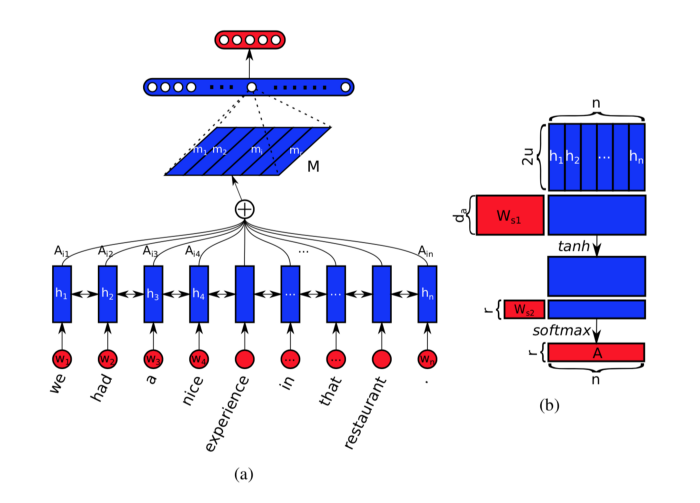

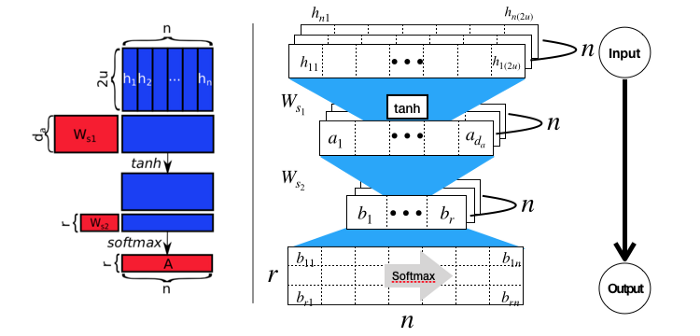

In [86]:
class Tweets(nn.Module):
    def __init__(self, weights_matrix, hidden_size, linear_hid, d, r):
        super(Tweets, self).__init__()
        self.hidden_size = hidden_size
        self.d = d
        self.r = r
        self.linear_hid = linear_hid
        self.embed, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, 
                            bidirectional=True)
        self.w1 = nn.Linear(2*hidden_size, d, bias=False)
        self.tanh = nn.Tanh()
        self.w2 = nn.Linear(d, r, bias = False)
        self.soft = nn.Softmax(dim=1)
        self.drop = nn.Dropout(.3)

        self.lin1 = nn.Linear(2*hidden_size, linear_hid)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(linear_hid, 2)

      
    def forward(self, x, hidden):
      
      batch_size = x.size(0)
      x = x.long()
      em = self.embed(x)
      
      out, hidden = self.lstm(em, hidden)
      
      out = self.drop(out)
     
      _w = self.tanh(self.w1(out))
      w = self.w2(_w)
      w = torch.abs(w)
      
      att = self.soft(w)
      
      att = w.transpose(dim0=1, dim1=2)
    
      m = torch.matmul(att, out)
      m = m.mean(dim=1)
      
      m = m.view(batch_size, -1)
      
      x = self.relu(self.lin1(m))
     
      x = self.lin2(x)

      return x, hidden

    def initHidden(self, batch_size):
        weight = next(self.parameters()).data
        if train_on_gpu:
          hidden = (weight.new(2, batch_size, self.hidden_size).zero_().cuda(), #//2
                  weight.new(2, batch_size, self.hidden_size).zero_().cuda())
        else:
          hidden = (weight.new(2, batch_size, self.hidden_size).zero_().cpu(), #//2
                  weight.new(2, batch_size, self.hidden_size).zero_().cpu())
        return hidden

hidden_size = 32
d = 10
r = 1
linear_hid = 200

net = Tweets(weights_matrix, hidden_size, linear_hid, d, r)

In [88]:
def count_parameters(model):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f'Number of parameters: {count_parameters(net)}')

#worked a little bit better than Adam/AdamW for me
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

epochs = 20
counter = 0
#clip = 5
print_every = 128

if train_on_gpu:
    net.cuda()

net.train()

Number of parameters: 73956


Tweets(
  (embed): Embedding(14964, 200)
  (lstm): LSTM(200, 32, batch_first=True, bidirectional=True)
  (w1): Linear(in_features=64, out_features=10, bias=False)
  (tanh): Tanh()
  (w2): Linear(in_features=10, out_features=1, bias=False)
  (soft): Softmax(dim=1)
  (drop): Dropout(p=0.3, inplace=False)
  (lin1): Linear(in_features=64, out_features=200, bias=True)
  (relu): ReLU()
  (lin2): Linear(in_features=200, out_features=2, bias=True)
)

In [89]:
best_f1 = 0

for epoch in range(epochs):
 
  train_res = []
  train_lab = []
  valid_res = []
  valid_lab = []

  hidden = net.initHidden(batch_size)
  for input, label in train_loader:

    counter += 1
    if train_on_gpu:
        input, label = input.cuda(), label.cuda()
    
    hidden = tuple([e.data for e in hidden])
    
    net.zero_grad()
    
    output, hidden = net(input, hidden)
    
    for i in output:
      train_res.append(int(torch.argmax(i)))
    
    for i in label:
      train_lab.append(int(i))
    
    loss = criterion(output,label.long())
    loss.backward()
    
    
    optimizer.step()
    
    acc = np.sum(np.array(train_res) == np.array(train_lab)) / len(np.array(train_lab))
    f1 = f1_score(train_lab, train_res)

  valid_hidden_state = net.initHidden(batch_size)
  valid_losses = []
  
  net.eval()
  for input, label in valid_loader:
    
    valid_hidden_state = tuple([e.data for e in valid_hidden_state])
    if train_on_gpu:
      input, label = input.cuda(), label.cuda()

    val_output, valid_hidden_state = net(input, valid_hidden_state)

    for i in val_output:
      valid_res.append(int(torch.argmax(i)))
    for i in label:
      valid_lab.append(int(i))

    val_loss = criterion(val_output, label.long())
    
    valid_losses.append(val_loss.item())
    
    
    val_acc = np.sum(np.array(valid_res) == np.array(valid_lab)) / len(np.array(valid_lab))
    val_f1 = f1_score(valid_lab, valid_res)

    #save model in case of valid f1 improvement
    if val_f1 > best_f1:
      torch.save(net.state_dict(), 'lstm_best_model_state.pt')
      best_f1 = val_f1
    
    
  net.train()

  print(f'Epoch: {epoch + 1}/{epochs}')
  print(f'Step: {counter}')
  print(f'Train F1: {f1}')
  print(f'Valid F1: {val_f1}')
  print(f'Train Loss: :{loss.item()}')
  print(f'Val Loss: {np.mean(valid_losses)}')


Epoch: 1/20
Step: 184
Train F1: 0.45739626227431107
Valid F1: 0.7368421052631579
Train Loss: :0.48067885637283325
Val Loss: 0.48111465314160223
Epoch: 2/20
Step: 368
Train F1: 0.6926492353231376
Valid F1: 0.7456382001836547
Train Loss: :0.4758208990097046
Val Loss: 0.4538613376410111
Epoch: 3/20
Step: 552
Train F1: 0.7066074950690335
Valid F1: 0.7598944591029024
Train Loss: :0.5293468832969666
Val Loss: 0.44096330942019174
Epoch: 4/20
Step: 736
Train F1: 0.7258574556069084
Valid F1: 0.7743589743589744
Train Loss: :0.6948351263999939
Val Loss: 0.4342759481590727
Epoch: 5/20
Step: 920
Train F1: 0.72820763956905
Valid F1: 0.7685589519650655
Train Loss: :0.37097635865211487
Val Loss: 0.43283796504787775
Epoch: 6/20
Step: 1104
Train F1: 0.7306182531894013
Valid F1: 0.7713787085514834
Train Loss: :0.38549378514289856
Val Loss: 0.43173257229120837
Epoch: 7/20
Step: 1288
Train F1: 0.739364303178484
Valid F1: 0.7692307692307693
Train Loss: :0.3409123122692108
Val Loss: 0.4324639672818391
Epoch:

78.62% is our new baseline F1 (Step: 2392)

In [90]:
#load the best model with 78.62% validation f1-score
net = Tweets(weights_matrix, hidden_size, linear_hid, d, r)
if train_on_gpu: net.cuda()
net.load_state_dict(torch.load('lstm_best_model_state.pt'))

<All keys matched successfully>

In [91]:
net.eval()
test_res = []

if train_on_gpu:
  input = torch.from_numpy(padded[len(all_sentences):,:]).cuda()
else: input = torch.from_numpy(padded[len(all_sentences):,:])

test_hidden_state = net.initHidden(input.shape[0])
test_hidden_state = tuple([e.data for e in test_hidden_state])


test_output, _ = net(input, test_hidden_state)
for i in test_output:
  test_res.append(int(torch.argmax(i)))

In [92]:
subm_lstm = pd.read_csv('sample_submission.csv')
subm_lstm['target'] = test_res
subm_lstm.to_csv('glove_lstm.csv', index=None)
# 0.80232 public score

# Twitter-roBERTa-base

This one is a RoBERTa transformer LLM trained on a twitter dataset (https://huggingface.co/cardiffnlp/twitter-roberta-base). We'll be finetuning it on our tweets dataset.

In [2]:
#PRE_TRAINED_MODEL_NAME = 'roberta-base'
PRE_TRAINED_MODEL_NAME = "cardiffnlp/twitter-roberta-base"
#PRE_TRAINED_MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, )

Determining max sentence length for a model based on how it tokenizes input tweets. From my experience, large pre-trained transformers work better with raw non-processed text, however, our modified RoBERTa model was trained on tweets processed by normalizing usernames and links, so we'll go with 'user_link_norm' field.

Max length:  70
                                        


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


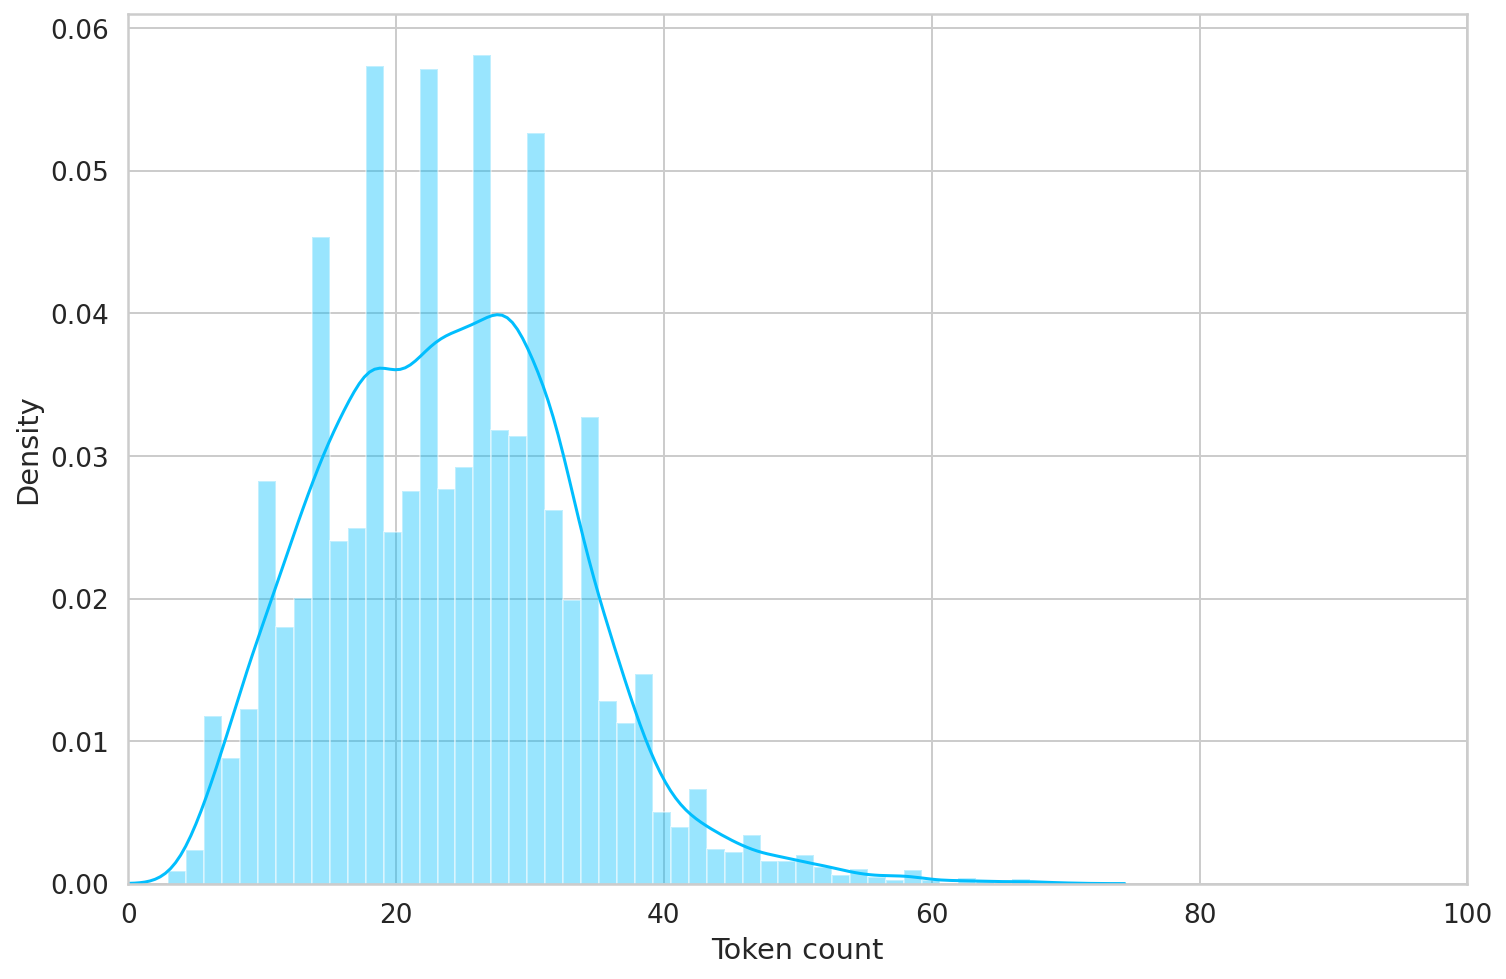

In [97]:
token_lens = []

for tweet in list(train_df.user_link_norm)+list(test_df.user_link_norm):
  tokens = tokenizer.encode(tweet, truncation=True, max_length=512)
  token_lens.append(len(tokens))

print('Max length: ', max(token_lens))
print(' '*40)

sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [98]:
MAX_LEN = 128

In [99]:
class TweetDataset(Dataset):

  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len, # 128
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

Train/test split

In [101]:
df_train, df_val = train_test_split(train_df, test_size=0.2, shuffle=False)

df_train.shape, df_val.shape

((5526, 6), (1382, 6))

In [134]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TweetDataset(
    tweets=df.user_link_norm.to_numpy(),
    labels=df.target_relabeled.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [135]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Instances of raw tweets, RoBERTa tokenized input (first token is 0, padding is 1), attention mask to tell between an actual input and a padding, and a label

In [104]:
print([i for i in train_data_loader][0]['tweet_text'][0])
print([i for i in train_data_loader][0]['input_ids'][0])
print([i for i in train_data_loader][0]['attention_mask'][0])
print([i for i in train_data_loader][0]['labels'][0])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
tensor([    0,  2522,   926, 12080,    32,     5, 31613,     9,    42,   849,
        25581,  2253,  5113,   392, 12389, 15334,   286, 26650,   201,    70,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,  

In [106]:
class DisasterClassifier(nn.Module):

  def __init__(self, n_classes):
    super(DisasterClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(.4)
    self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    
    output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_1[0]
    pooler = hidden_state[:, 0]
    output = self.drop(pooler) #using RoBERTa pooler output (first token) as tweets representation for classification
    return self.out(output)

In [107]:
model = DisasterClassifier(2)
model = model.to(device)

print(model)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DisasterClassifier(
  (deberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [108]:
data = next(iter(train_data_loader))
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) #bs x max_length
print(attention_mask.shape)

torch.Size([32, 128])
torch.Size([32, 128])


In [109]:
EPOCHS = 6 #only few epochs needed thanks to good pre-existing modelling abilities

optimizer = AdamW(model.parameters(), lr=5e-6)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Auxiliary functions

In [110]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  y_pred_tr = []
  y_true_tr = []

  losses = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1) # choose index with max value
    
    loss = loss_fn(outputs, labels)
    
    for i in preds.cpu().numpy():
        y_pred_tr.append(i)
    for i in labels.cpu().numpy():
        y_true_tr.append(i)
    
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return accuracy_score(y_true_tr, y_pred_tr), np.mean(losses), \
         f1_score(y_true_tr, y_pred_tr)

In [111]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []

  y_pred_val = []
  y_true_val = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      for i in preds.cpu().numpy():
        y_pred_val.append(i)
      for i in labels.cpu().numpy():
        y_true_val.append(i)

      losses.append(loss.item())

  return accuracy_score(y_true_val, y_pred_val), np.mean(losses), \
         f1_score(y_true_val, y_pred_val), \
         classification_report(y_true_val, y_pred_val)

12 Gb Tesla K80

In [112]:
!nvidia-smi

Mon Jan 17 10:22:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    58W / 149W |   1279MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [113]:
%%time

history = defaultdict(list)
best_f1 = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, train_f1 = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss: {train_loss}, Accuracy: {train_acc}, f1: {train_f1}')

  val_acc, val_loss, val_f1, _ = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss: {val_loss}, Accuracy: {val_acc}, f1: {val_f1}')
  
  # saving to history
  history['train_acc'].append(train_acc.item())
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss.item())
  history['train_f1'].append(train_f1.item())
  history['val_f1'].append(val_f1.item())

  # if current f1 is larger than the previous one, save the model
  if val_f1 > best_f1:
    torch.save(model.state_dict(), 'best_model_state.pt')
    best_f1 = val_f1

Epoch 1/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss: 0.6656837182582458, Accuracy: 0.5624321389793703, f1: 0.5480373831775701


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val loss: 0.4282198072495786, Accuracy: 0.821273516642547, f1: 0.7693744164332399
Epoch 2/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss: 0.45311364665024545, Accuracy: 0.820123054650742, f1: 0.7542037586547973


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val loss: 0.3615198606963862, Accuracy: 0.8386396526772794, f1: 0.7996406109613657
Epoch 3/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss: 0.3974292033454242, Accuracy: 0.8445530220774521, f1: 0.7895123744180348


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val loss: 0.35571162131699646, Accuracy: 0.8429811866859623, f1: 0.8111401218450826
Epoch 4/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss: 0.3639339548078059, Accuracy: 0.8579442634817228, f1: 0.808583272372592


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val loss: 0.35561788649382914, Accuracy: 0.8458755426917511, f1: 0.8168529664660361
Epoch 5/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss: 0.3511924102600944, Accuracy: 0.8666304741223309, f1: 0.8197603325996576


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val loss: 0.3571572597561912, Accuracy: 0.8422575976845152, f1: 0.8136752136752138
Epoch 6/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss: 0.33485612710345686, Accuracy: 0.8713355048859935, f1: 0.826458384183549


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val loss: 0.36120899085124786, Accuracy: 0.8408104196816208, f1: 0.8122866894197952
CPU times: user 22min 16s, sys: 19.5 s, total: 22min 36s
Wall time: 22min 40s


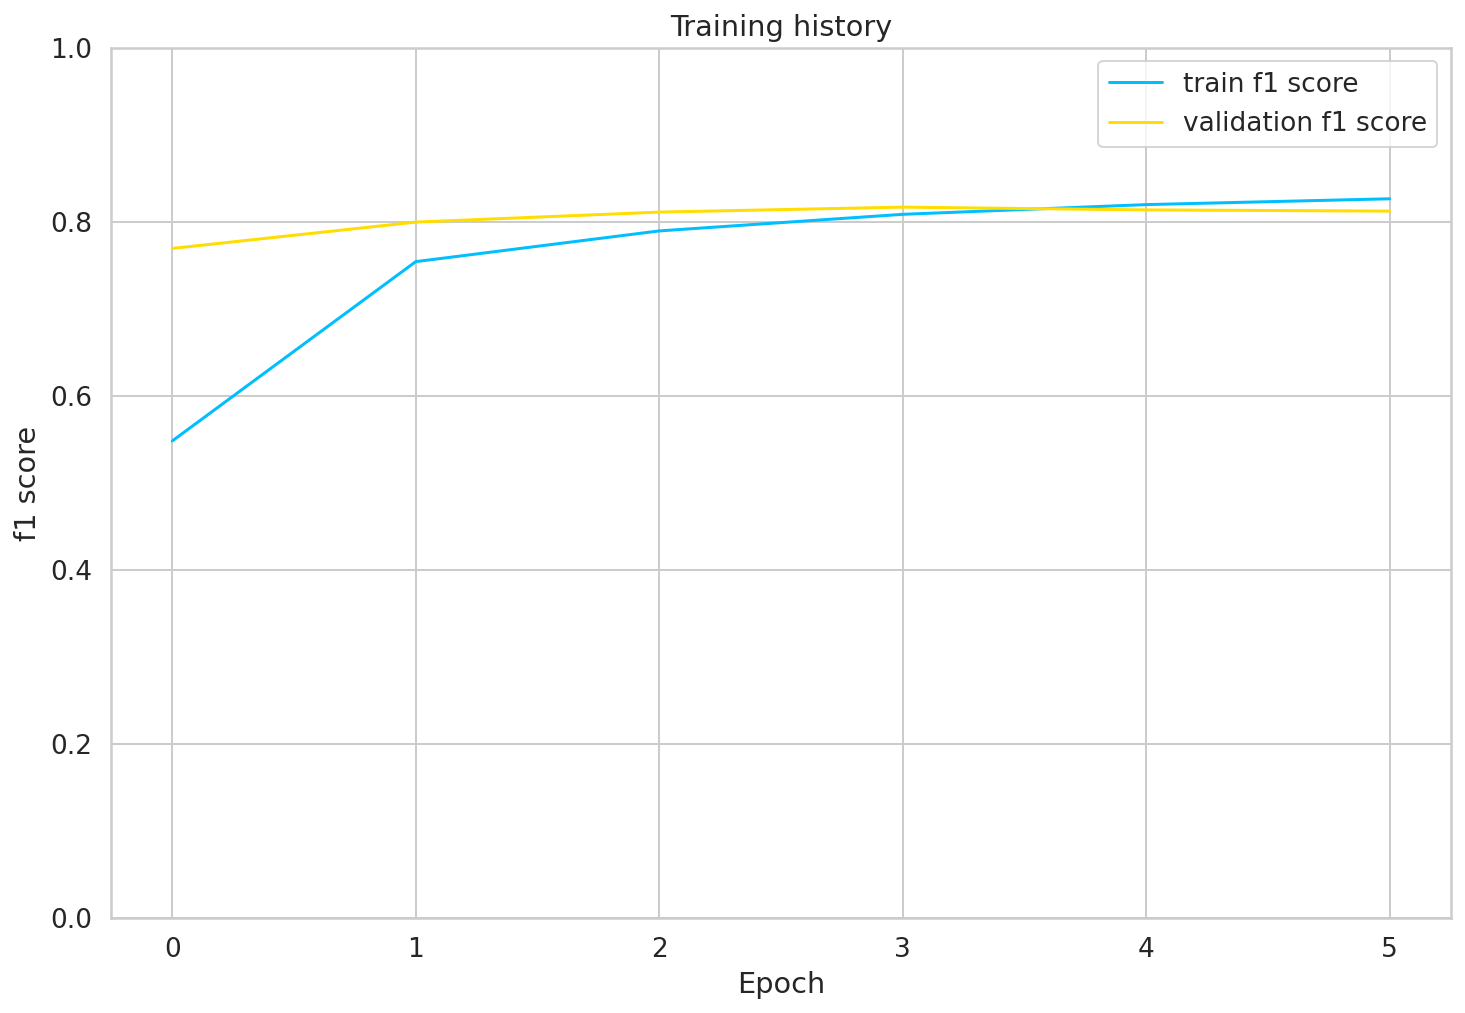

In [114]:
plt.plot(history['train_f1'], label='train f1 score')
plt.plot(history['val_f1'], label='validation f1 score')

plt.title('Training history')
plt.ylabel('f1 score')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

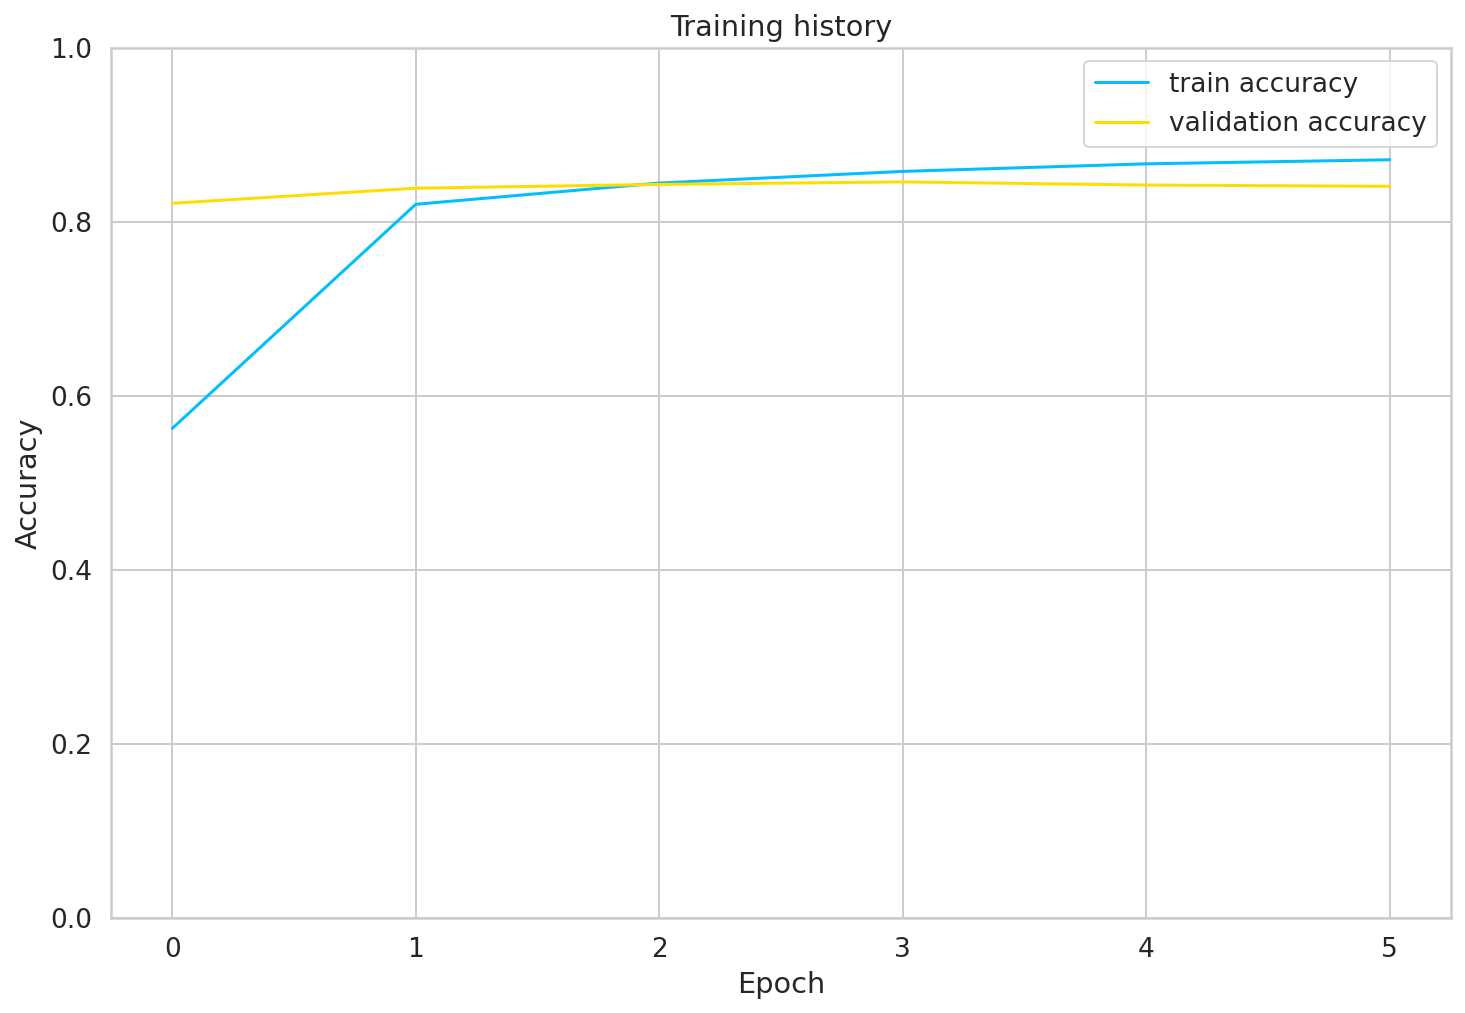

In [115]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

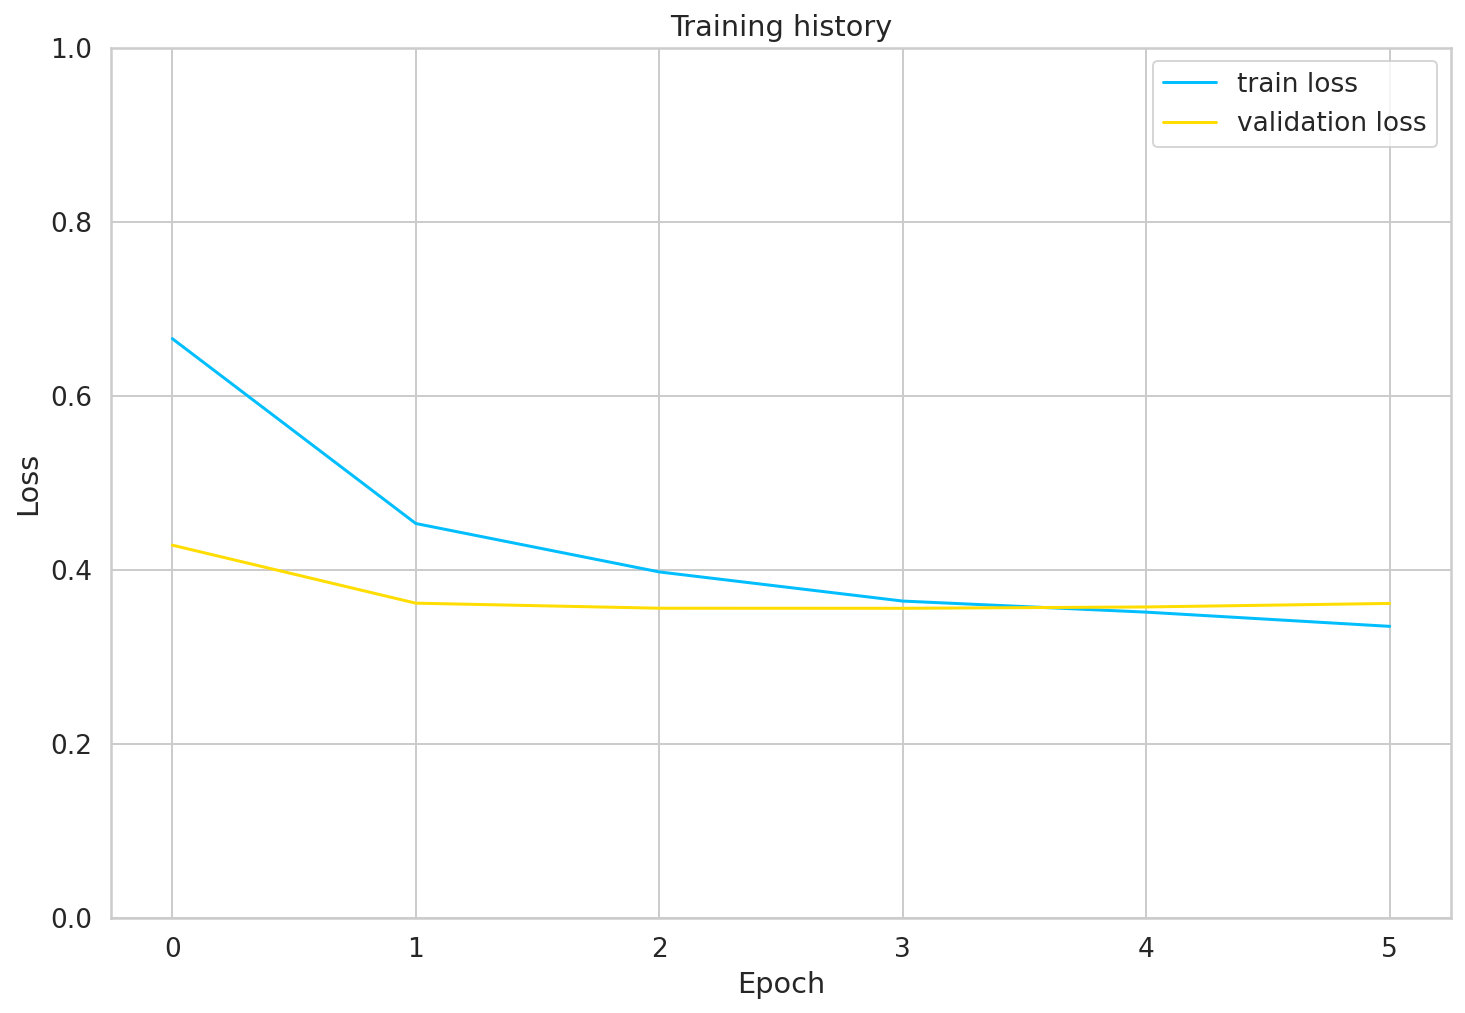

In [116]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [131]:
model = DisasterClassifier(2)
model = model.to(device)
model.load_state_dict(torch.load('best_model_state.pt'))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Full classification report on the validation set. We're seeing that the model has a little more trouble detecting real disaster tweets, with disaster recall being `0.77` against `0.90` for fake disaster. Precision is better for real ones, meaning the model is 'cleaner' at determining disaster tweets. Most likely, this is due to dataset imbalance.

Overall test f1-score on 1382 tweets is about `81.69%` and test accuracy is ~`85%`, which is the best result so far.

In [136]:
valid_acc, _, val_f1, report = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(df_val)
)
print(f'Valid f1 score: {round(val_f1*100, 3)}%')
print(f'Valid accuracy: {round(valid_acc.item()*100, 3)}%')
print('Report:')
print(report)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid f1 score: 81.685%
Valid accuracy: 84.588%
Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       769
           1       0.86      0.77      0.82       613

    accuracy                           0.85      1382
   macro avg       0.85      0.84      0.84      1382
weighted avg       0.85      0.85      0.84      1382



Let's have a quick look at how our model behaves on custom pseudo tweets. The first one is supposed to be about a real disaster, while the second one is a kind of imitation.

In [127]:
test_tweet_1 = '15,000 people have died because of the earthquakes last year'
test_tweet_2 = 'OMG have you seen those spindrift clouds? They are monstrous!'

In [129]:
tknzd = [tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    ) for tweet in [test_tweet_1, test_tweet_2]]

As we can see, the model correctly identifies both tweets, however, it has somewhat lower confidence when predicting a label for non-disaster tweets.

In [130]:
model.eval()

for i in tknzd:
    out = model(i["input_ids"].cuda(), i["attention_mask"].cuda())
    pred = torch.argmax(out)
    # softmax probability for chosen class
    confidence = torch.max(F.softmax(out, dim=1)).detach().cpu().numpy()
    if pred==0:
        res = 'non-disaster'
    else: res = 'disaster'
        
    print(f'Result: {res}, confidence: {round(confidence*100, 2)}%')

Result: disaster, confidence: 99.54%
Result: non-disaster, confidence: 93.66%


Finally, submitting our predictions for the competition.

In [121]:
test_t_data_loader = DataLoader([tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    ) for tweet in test_df.user_link_norm.values], batch_size=BATCH_SIZE)

In [122]:
def get_test_predictions(model, data_loader):
  model = model.eval()

  predictions = []
 
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].squeeze().to(device)
      attention_mask = d["attention_mask"].squeeze().to(device)
      
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      preds = torch.argmax(outputs, dim=1)     
      predictions.extend(preds)

  return torch.stack(predictions).cpu()

In [123]:
subm = pd.DataFrame({
    'id': test_df.id,
    'target': get_test_predictions(model, test_t_data_loader).numpy()
})

subm.to_csv('subm_roberta.csv', index=False)
# 0.84125 public score

# Some other possible approaches to consider:

1. Different vectorization and modelling techniques combination - e.g. utilizing LLMs (BERT/RoBERTa/DeBERTa, etc.) embeddings as vectors for various ML/DL classifiers, including gradient boosting models, LSTM+CNN neural nets, etc. As for pre-trained embeddings, we could enable further fine-tuning these along with a neural net (as a regular embedding layer) instead of freezing them.
2. Utilizing keywords and location info. The most straightforward option is to concatenate these with the text field ad feed into model, but one could also try to use an ensemble-like approach where primary model labels predictions are combined with vectorized keywords and locations to form a new features set for a new model.
3. Extensively analyze, clean and process the data, fixing human labeling flaws, removing ambigious samples, etc.
4. Further playing with RoBERTa hyperparams, including optimizer, lr, scheduler, bs, max sequence length (e.g. set to 64 or max tweet length in a dataset), etc.


As a standalone point, we could also train our models on the whole train set (includng what we've used for validation) before testing them on Kaggle. That is how it's done in the real world and this probably would've given better results.